# Example how to use STAC, xarray and dask

This example shows how tu use [STAC](https://stacspec.org/en/about/) (Spatio-Temporal Asset Catalog), [xarray](https://docs.xarray.dev/en/stable/) and [Dask](https://www.dask.org/) for processing big raster datasets, also with good support for time series. The main idea is to first define the search and processing as process graph. The downloading and processing is done lazily at the end, so that only needed data (good enough cloud-free image, only needed bands and area) is downloaded. The libraries take care of data download, so you do not need to know about file paths. These tools work best when data is provided as [Cloud-optimized GeoTiffs](https://www.cogeo.org/) (COGs).

For trying out this example, it is recommended to start interactive [Jupyter session](https://docs.csc.fi/computing/webinterface/jupyter/) with [Puhti web interface](https://docs.csc.fi/computing/webinterface/), for example with 4 cores and 12 Gb memory.

Dask is used for parallization of computing, see [CSC Dask tutorial](https://docs.csc.fi/support/tutorials/dask-python/), inc how to use Dask with Jupyter in
Puhti web interface and how to create batch jobs with Dask.

We'll search for 12 months of Sentinel-2 data overlapping cetnral Helsinki. Then filter out cloudy scenes, based on their metadata, then create a median composite for each month.

The main steps:
* Start Dask cluster
* Query STAC catalogue to find Sentinel2 L2A images from area and time of interest and create first datacube.
* Removing images with too high cloud coverage.
* Selecting only required bands.
* Mosaic the images with median value, for each month.
* Select data only from exact area of interest.
* Finally, calculate the result.
* Close Dask cluster

In this example [Element84 STAC catalogue](https://www.element84.com/earth-search/) `sentinel-s2-l2a-cogs` collection on AWS is used, but there are several [other STAC catalogues available](https://stacspec.org/en/about/datasets/).

This example works with [geoconda module](https://docs.csc.fi/apps/geoconda/) in Puhti, the required libraries can be seen from imports.

The example is mostly based on [Stackstac documentation](https://stackstac.readthedocs.io/en/latest/basic.html)

In [2]:
import stackstac
from dask.distributed import Client
import pystac_client
import pyproj

Start Dask cluster. 

For following how Dask works open [Dask Dashboard or JupyterLab Dask Extension](https://docs.csc.fi/support/tutorials/dask-python/#dask-with-jupyter).

In [3]:
client = Client()
client

<Client: 'tcp://127.0.0.1:38280' processes=4 threads=4, memory=12.00 GiB>

Define the center of area of interest, in this case Helsinki.

In [4]:
lon, lat = 24.945, 60.173, 

Search from STAC API, using [pystac-client](https://pystac-client.readthedocs.io/). If using some other STAC catalogue, change the URL. 

In [3]:
# Define STAC API URL and create
URL = "https://earth-search.aws.element84.com/v0"
catalog = pystac_client.Client.open(URL)

Find out which collections are available.

In [4]:
for collection in catalog.get_collections():
    print(collection.id)

sentinel-s2-l2a
sentinel-s2-l1c
sentinel-s2-l2a-cogs
landsat-8-l1-c1


Define search critera, here location, collection (`sentinel-s2-l2a-cogs`) and time period. The results provide metadata about the relevant scenes, and links to their data.

In [6]:
%%time
items = catalog.search(
    intersects=dict(type="Point", coordinates=[lon, lat]),
    collections=["sentinel-s2-l2a-cogs"],
    datetime="2020-01-01/2020-12-01"
).get_all_items()
len(items)

CPU times: user 140 ms, sys: 83 ms, total: 223 ms
Wall time: 3.43 s


134

Create `xarray` datacube from the items. Using all the defaults, our data will be in its native coordinate reference system, at the finest resolution of all the assets. This will be fast, because the actual data is not fetched yet. 

In [7]:
%time stack = stackstac.stack(items)

CPU times: user 51.1 ms, sys: 3.25 ms, total: 54.4 ms
Wall time: 51.9 ms


How does the datacube look like?

In [8]:
stack

<xarray.DataArray 'stackstac-abaf65da5693ab5669805e89bdbbce56' (time: 134,
                                                                band: 17,
                                                                y: 10980,
                                                                x: 10980)>
dask.array<fetch_raster_window, shape=(134, 17, 10980, 10980), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/27)
  * time                        (time) datetime64[ns] 2020-01-05T09:43:50 ......
    id                          (time) <U24 'S2B_35VLG_20200105_0_L2A' ... 'S...
  * band                        (band) <U8 'overview' 'B11' ... 'visual' 'SCL'
  * x                           (x) float64 3e+05 3e+05 ... 4.098e+05 4.098e+05
  * y                           (y) float64 6.7e+06 6.7e+06 ... 6.59e+06
    gsd                         (band) object 10 20 60 20 10 ... 60 None 10 None
    ...                          ...
    data_coverage               (time) object 82.42 100 82.61 ... None None None
    title                       (band) <U31 'True color image' ... 'Scene Cla...
    common_name                 (band) object None 'swir16' ... None None
    center_wavelength           (band) object None 1.6137 0.4439 ... None None
    full_width_half_max         (band) object None 0.143 0.027 ... None None
    epsg                        int64 32635
Attributes:
    spec:        RasterSpec(epsg=32635, bounds=(300000.0, 6590220.0, 409800.0...
    crs:         epsg:32635
    transform:   | 10.00, 0.00, 300000.00|\n| 0.00,-10.00, 6700020.00|\n| 0.0...
    resolution:  10.0

Filter out scenes with >20% cloud coverage (according to the `eo:cloud_cover` field set by the data provider).
Then, pick the bands corresponding to red, green, and blue, and use xarray's `resample` to create 1-month median composites.

In [9]:
lowcloud = stack[stack["eo:cloud_cover"] < 20]
rgb = lowcloud.sel(band=["B04", "B03", "B02"])
monthly = rgb.resample(time="MS").median("time", keep_attrs=True)

With these limitation the amount of data has decreased from 2 TB to ~30 Gb.

In [10]:
monthly

<xarray.DataArray 'stackstac-abaf65da5693ab5669805e89bdbbce56' (time: 11,
                                                                band: 3,
                                                                y: 10980,
                                                                x: 10980)>
dask.array<stack, shape=(11, 3, 10980, 10980), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/17)
  * time                    (time) datetime64[ns] 2020-01-01 ... 2020-11-01
  * band                    (band) <U8 'B04' 'B03' 'B02'
  * x                       (x) float64 3e+05 3e+05 ... 4.098e+05 4.098e+05
  * y                       (y) float64 6.7e+06 6.7e+06 ... 6.59e+06 6.59e+06
    gsd                     (band) object 10 10 10
    sentinel:grid_square    <U2 'LG'
    ...                      ...
    sentinel:utm_zone       int64 35
    title                   (band) <U31 'Band 4 (red)' ... 'Band 2 (blue)'
    common_name             (band) object 'red' 'green' 'blue'
    center_wavelength       (band) object 0.6645 0.56 0.4966
    full_width_half_max     (band) object 0.038 0.045 0.098
    epsg                    int64 32635
Attributes:
    spec:        RasterSpec(epsg=32635, bounds=(300000.0, 6590220.0, 409800.0...
    crs:         epsg:32635
    transform:   | 10.00, 0.00, 300000.00|\n| 0.00,-10.00, 6700020.00|\n| 0.0...
    resolution:  10.0

Convert lat-lon point to the data's UTM coordinate reference system, then use that to slice the `x` and `y` dimensions, which are indexed by their UTM coordinates.

In [11]:
x_utm, y_utm = pyproj.Proj(monthly.crs)(lon, lat)
buffer = 2000  # meters

aoi = monthly.loc[..., y_utm+buffer:y_utm-buffer, x_utm-buffer:x_utm+buffer]
aoi

<xarray.DataArray 'stackstac-abaf65da5693ab5669805e89bdbbce56' (time: 11,
                                                                band: 3,
                                                                y: 400, x: 400)>
dask.array<getitem, shape=(11, 3, 400, 400), dtype=float64, chunksize=(1, 1, 400, 400), chunktype=numpy.ndarray>
Coordinates: (12/17)
  * time                    (time) datetime64[ns] 2020-01-01 ... 2020-11-01
  * band                    (band) <U8 'B04' 'B03' 'B02'
  * x                       (x) float64 3.84e+05 3.84e+05 ... 3.88e+05 3.88e+05
  * y                       (y) float64 6.674e+06 6.674e+06 ... 6.67e+06
    gsd                     (band) object 10 10 10
    sentinel:grid_square    <U2 'LG'
    ...                      ...
    sentinel:utm_zone       int64 35
    title                   (band) <U31 'Band 4 (red)' ... 'Band 2 (blue)'
    common_name             (band) object 'red' 'green' 'blue'
    center_wavelength       (band) object 0.6645 0.56 0.4966
    full_width_half_max     (band) object 0.038 0.045 0.098
    epsg                    int64 32635
Attributes:
    spec:        RasterSpec(epsg=32635, bounds=(300000.0, 6590220.0, 409800.0...
    crs:         epsg:32635
    transform:   | 10.00, 0.00, 300000.00|\n| 0.00,-10.00, 6700020.00|\n| 0.0...
    resolution:  10.0

So far no data has been downloaded, nor anything computed with actual data. Data size has become 40 Mb, which will actually be downloaded. In this example the final data size is very small, but Dask is good also in handling much bigger amounts of data, also bigger than fits to memory.

To start the process use `compute()`. The process can be followed from Dask Dashboard or Dask Lab Extension.

In [12]:
%%time
data = aoi.compute()

CPU times: user 3.14 s, sys: 1.04 s, total: 4.19 s
Wall time: 40.8 s


Show the resulting images.

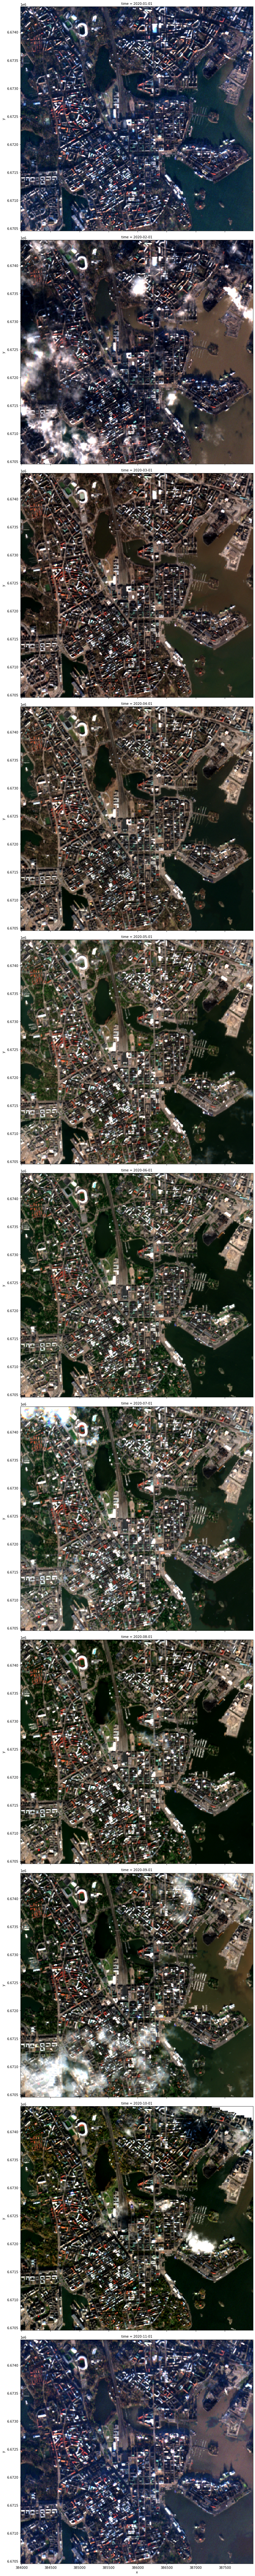

In [13]:
data.plot.imshow(row="time", rgb="band", robust=True, size=10);

Close Dask cluster.

In [ ]:
client.shutdown()